In [43]:
import kagglehub
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Download latest version
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

destPath = "C:/Users/USER/OneDrive/Documentos/Maestria Ingenieria Electronica/Prueba_Tecnica/dataset"

os.makedirs(destPath, exist_ok=True)

for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(destPath, file)
    shutil.copy(src, dst)

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\sumanthvrao\daily-climate-time-series-data\versions\3


Observacion inicial de los datos 

In [44]:

pathDs = "C:/Users/USER/OneDrive/Documentos/Maestria Ingenieria Electronica/Prueba_Tecnica/dataset/DailyDelhiClimateTrain.csv"

df = pd.read_csv(pathDs)
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [45]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)

Se obtiene informacion relevante del data set

In [46]:
print(df.head())
print(df.info())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None


## Seccion 1: Analisis de Serie Temporal

### Visualización completa de la Serie

In [ ]:
Se graficarán todos los datos en figuras diferente para ver la serie completa en el tiempo y su comportamiento. 

<Figure size 1500x1000 with 0 Axes>

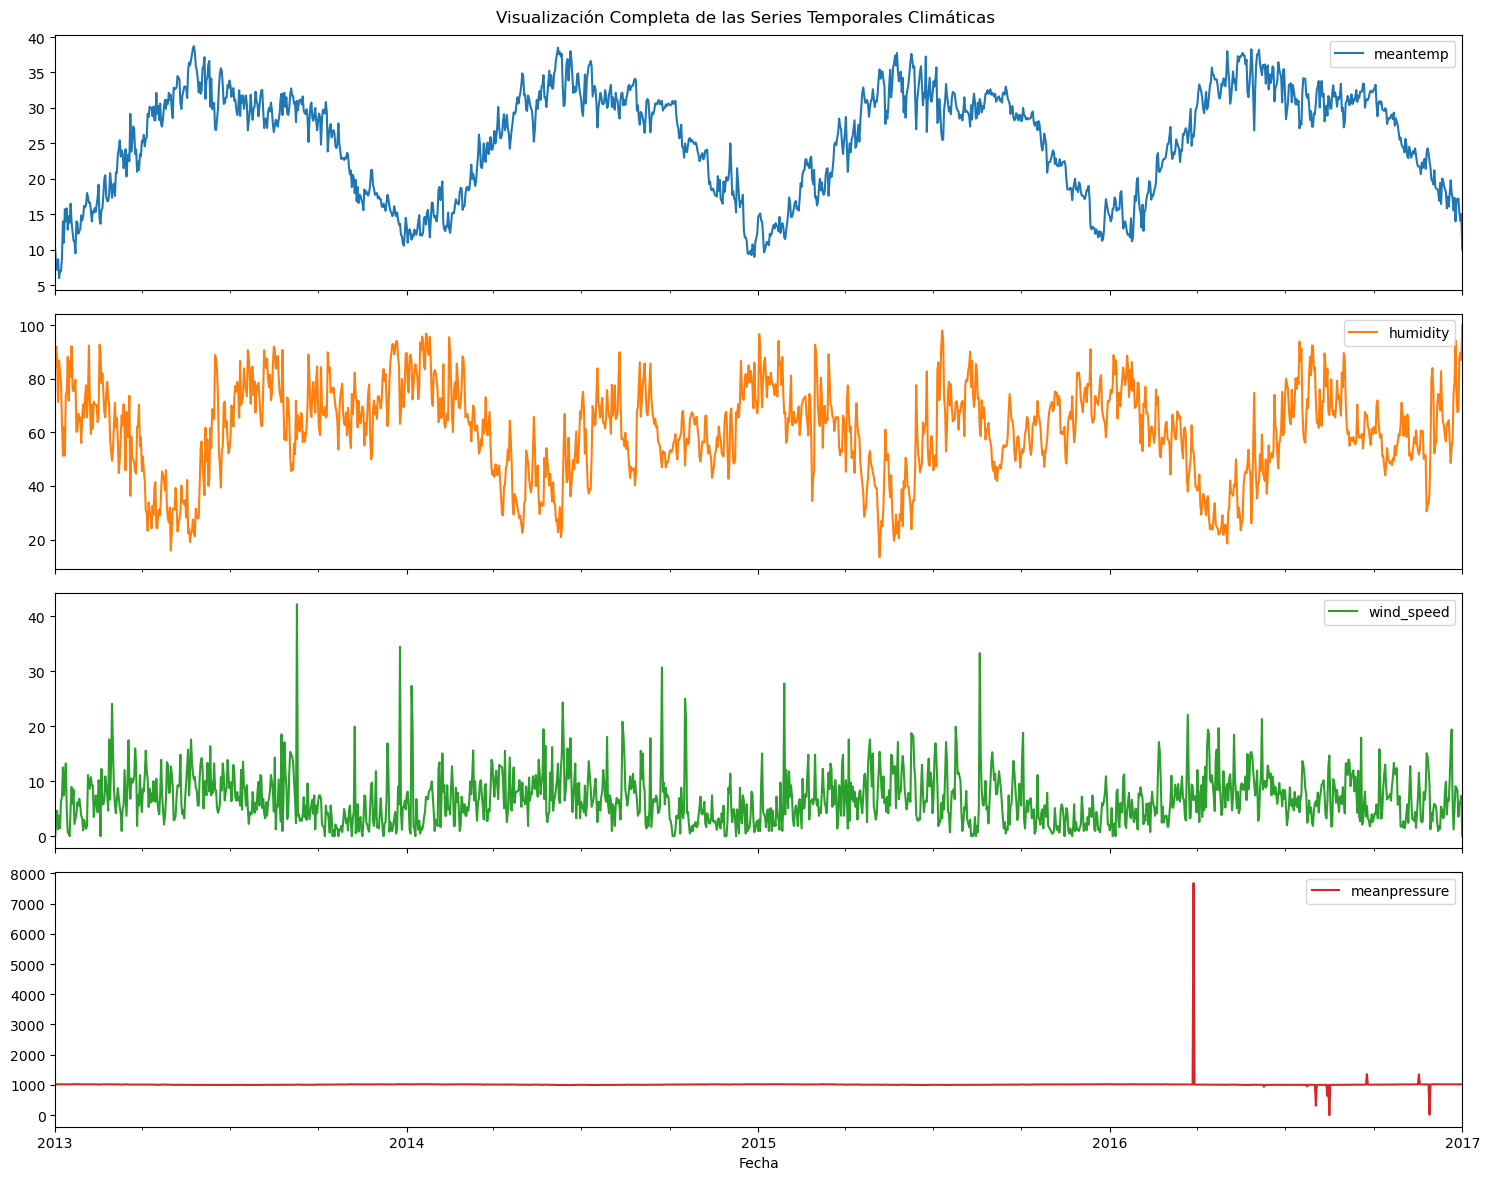

In [48]:
plt.figure(figsize=(15, 10))

df.plot(subplots=True, 
        figsize=(15, 12), 
        layout=(4, 1), 
        title='Visualización Completa de las Series Temporales Climáticas')

plt.xlabel('Fecha') 
plt.tight_layout() 
plt.show()

### Hallazgos
Se puede observar que la humedar y la temperatura aparenteme estan inversamente corralecionadas ya que a mayor temperatura hay menor humedad

### Identificacion de componentes
    - Tendenncia
    - Estacionalidad
    - Patrones anomalos

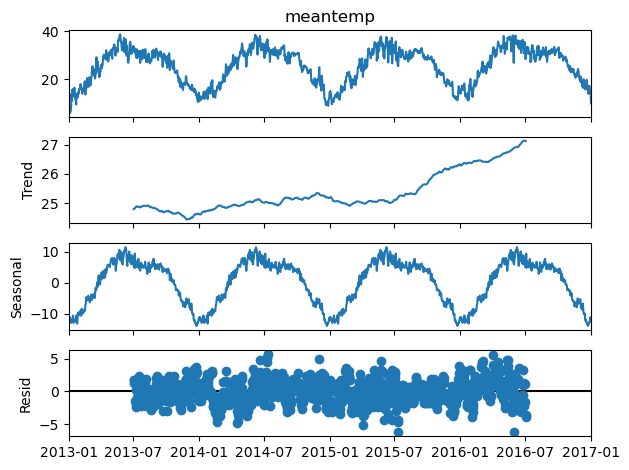

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la temperatura media (Tendencia, Estacionalidad, Residuales)
decomposition = seasonal_decompose(df['meantemp'], model='additive', period=365)
decomposition.plot()
plt.show()

### Hallazgos

#### 1. Serie original (meantemp)
En la primera grafica se observa la temperatura media dirai durante varios años. 

    - Se identifica un patron ciclico anual muy claro (la temperatura aumenta y disminuye cada año.)
    - Esto indica estacionalidad fuerte. Confirma el ciclo natural de la temperatura (frio en invierno, calor en verano). 
    - No se observan valores que parezcan fuera de rango asi que no es evidente la presencia de anomalias severas. 

#### 2. Tendencia (trend)

    - Desde 2013 a 2016 hay una tendencia ascendete suave, esto sugiere que en general las temperaturas medias umentan ligeramente con el tiempo.
    - Hay una tendencia positiva, por lo que el modelo LTSM debe capturar ademas de estacionalidad. 

#### 3. Residual (resid)

    - los datos se encuentran distribuidos al rededor de cero. 
    - No se observa una estructura clara (es buena señal)
    - los puntos dispersos podrian significar dias anomalos pero no son relevantes. 

### Resumen 

La serie de temperatura media presenta una tendencia ascendente moderada y una estacionalidad anual muy marcada, con picos y valles claramente definidos cada 12 meses.
Los residuos no muestran patrones sistemáticos, lo que sugiere que la variabilidad restante es principalmente aleatoria.
Estos hallazgos confirman que la serie es adecuada para modelado con redes LSTM, que son especialmente efectivas para aprender patrones temporales y estacionales complejos.

    


## Sección 2: Preparación de Datos

### Estructurar los datos para el modelo LSTM: 


Se procede a calcular lo retardos temporales.  
    - `Lag_1`:  Valor de temperatura de ayer.  
    - `Lag_7`: Valor de temperatura de hace una semana.   
    - `Lag_30`: Valor de temperatura de hace un mes.  

In [55]:

df['lag_1'] = df['meantemp'].shift(1) #shift crea una columna son el valor del dia anterior
df['lag_7'] = df['meantemp'].shift(7) #7 y 30 permite que el modelo vea como cambia la temperatura semanal o mensual 
df['lag_30'] = df['meantemp'].shift(30)

Medias moviles, calculan el promedio de los ultimos 7 o 30 dias. 

Estas tranformacion ayudan al modelo a recordar lel paso reciente (Lags) y suavizar fluctuaciones (medias moviles)

In [56]:

df['rolling_mean_7'] = df['meantemp'].rolling(window=7).mean()
df['rolling_mean_30'] = df['meantemp'].rolling(window=30).mean()

Se procede a eliminar los valores nulos por que los primeros 30 registros no tienen los suficienten dias previos para calcular los lags y los rolling_means 

In [72]:
df = df.dropna().reset_index(drop=True)

Normalizacion de datos, este paso se hace necesario ya que el LTSM es muy sensible a magnitudes distinas por esto realizamos el escado todo  a [0,1]

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['meantemp', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30']])

Crear Secuencias temporales.

Se crea la funcion create_sequences que en otras palabras el modelo debe aprender a usar 30 dias atenriores para predecir los proximos 7. 

In [74]:
import numpy as np
def create_sequences(data, input_steps=30, output_steps=7):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i : i + input_steps])           
        y.append(data[i + input_steps : i + input_steps + output_steps, 0])  
    return np.array(X), np.array(y)


In [89]:
# secuencias 
X, y = create_sequences(scaled_features, input_steps=30, output_steps=7)

# División temporal 
train_size = int(len(X) * 0.7) #70%
val_size = int(len(X) * 0.15) #14%

#datos de entrenamiento
X_train = X[:train_size]
y_train = y[:train_size]

#datos de validacion
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

#datos de test (dentro del mismo dataset)
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


In [76]:
print("Train:", X_train.shape, "Validation", X_val.shape, "Test:", X_test.shape)

Train: (976, 30, 6) Validation (209, 30, 6) Test: (210, 30, 6)


### Diseño del modelo LTSM 

#### Arquitectura propuesta por la prueba.
   
| | | | | | | | | 
|---|---|---|---|---|---|---|---|
| LSTM(50)| → |Dropout(0.2)| → |LSTM(50)| → |Dropout(0.2)| → |Dense(7)|


    - Primera capa LTSM: 50 neuronas.
    - Dropout(0.2): apaga aleatoriamente el 20% de las neuronas para evitar el sobreajuste.
    - Segunda capa LTSM: otra capa recurrente, tambien con 50 unidades.
    - Segundo Dropout(0.2): igual, regulariza la red.
    - Dense(7) capa densa final con 7 dias, porque predeciremos los 7 dias futuros.
      
Para la compilacion del modelo, se tuliza como optimizador adam, debido a que es un optimizador avanzado que combina lo mejor de SGD con momentum y RMSProp, ajusta de forma automatica la tasa de aprendizaje para cada peso en funcion de su historial de gradientes. Se decide usar este por que la series de tiempo suelen tener ruido y dependencias largas y Adam esmas estable y eficiente para este tipo de problemas en comparacion con SGD y Adagrad. 

la funcion de perdia MSE (Mean Sqared Error)
estandar en problemas de regreseion continua, como prediccion de temperatura precios y demanda tambien permite que el modelo aprenda a minizar los errores grandes primero. 

Metrica de  evaluacion, MAE (Mean Absolute Error)
me da el promedio real de desviacion que se tiene, es mas facil de interpretar. 


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# arquitectura del modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(7)  # 7 salidas → predicción de una semana
])

# Compilacion
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             357 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,957 (124.83 KB)

 Trainable params: 31,957 (124.83 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,        # si no mejora en 10 epochs → detiene
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # reduce el learning rate a la mitad
    patience=5,         # si no mejora en 5 epochs
    min_lr=1e-6
)


In [80]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0893 - mae: 0.2294 - val_loss: 0.0232 - val_mae: 0.1293 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0293 - mae: 0.1350 - val_loss: 0.0151 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0221 - mae: 0.1168 - val_loss: 0.0098 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0187 - mae: 0.1070 - val_loss: 0.0081 - val_mae: 0.0737 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0179 - mae: 0.1060 - val_loss: 0.0102 - val_mae: 0.0825 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0173 - mae: 0.1023 - val_loss: 0.0074 - val_mae: 0.0705 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0160 - mae: 0.0991 - val_loss: 0.0068 - val_mae: 0.0672 - learning_rate: 0.0010
Epoch

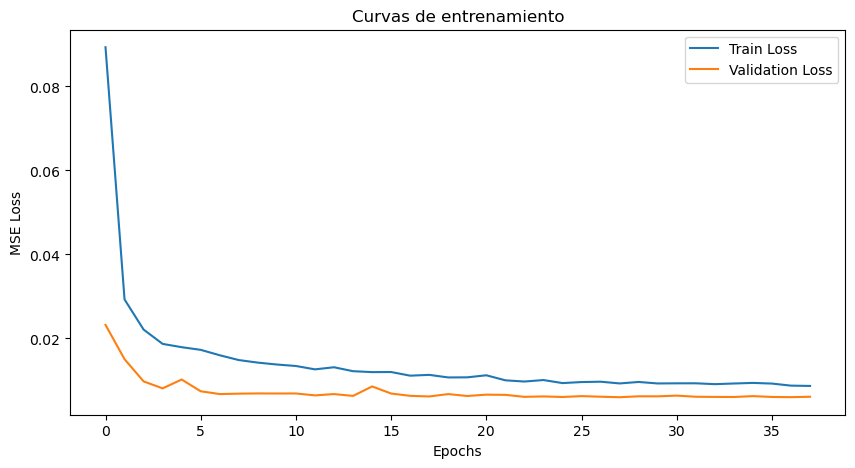

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Curvas de entrenamiento")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


### Analisis de las curvas de entrenamiento.

El modelo muestra una corvengencia rapida durante las priemras epocas y lusgo alcana una perdida estabe y baja, esto indica que el modelo esta aprendiendo correctamente sin signos evidentes de sobreajuste ni subajuste. 
El uso de los callbakcs ayuda en gran medida a estabilizar el proceso de entrenamiento evitando un exceso de epochs innecesarias. 


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Predicciones del modelo LSTM ---
y_pred_lstm = model.predict(X_test)

# Aplanar las predicciones y valores reales
y_pred_flat = y_pred_lstm.flatten()
y_test_flat = y_test.flatten()

# --- Cálculo de métricas ---
rmse_lstm = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae_lstm = mean_absolute_error(y_test_flat, y_pred_flat)

print(f"LSTM RMSE: {rmse_lstm:.4f}")
print(f"LSTM MAE:  {mae_lstm:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
LSTM RMSE: 0.0683
LSTM MAE:  0.0547


## Seccion 4: Evaluacion comparativa 


In [90]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


window_size = 7 
y_test = np.array(y_test) 


baseline_preds = []
y_true_baseline = []


for i in range(window_size, len(y_test)):
   
    pred = np.mean(y_test[i-window_size:i])
    baseline_preds.append(pred)
    
   
    y_true_baseline.append(y_test[i])

y_true_baseline = np.array(y_true_baseline).flatten()
baseline_preds = np.array(baseline_preds).flatten()

min_len = min(len(y_true_baseline), len(baseline_preds))
y_true_baseline = y_true_baseline[:min_len]
baseline_preds = baseline_preds[:min_len]


baseline_rmse = np.sqrt(mean_squared_error(y_true_baseline, baseline_preds))
baseline_mae = mean_absolute_error(y_true_baseline, baseline_preds)


print("Evaluación modelo baseline (media móvil):")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")


Evaluación modelo baseline (media móvil):
RMSE: 0.2270
MAE: 0.1765


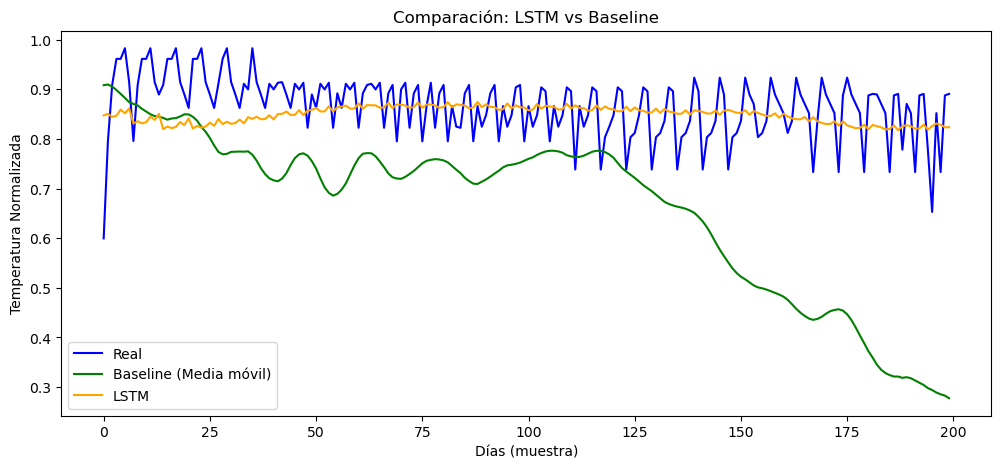

In [88]:
plt.figure(figsize=(12,5))
plt.plot(y_test_flat[:200], label="Real", color='blue')
plt.plot(baseline_preds[:200], label="Baseline (Media móvil)", color='green')
plt.plot(y_pred_flat[:200], label="LSTM", color='orange')
plt.title("Comparación: LSTM vs Baseline")
plt.xlabel("Días (muestra)")
plt.ylabel("Temperatura Normalizada")
plt.legend()
plt.show()


## Comparacion  ltsm vs Modelo Base Line

| Modelo | RMSE | MAE|
|---|---|---|
|Base Line (Media movil) | 0.227 | 0.176 |
| LTSM (Propuesto) | 0.068 | 0.054 | 

Los resultados muestran que el modelo LSTM reduce el error promedio absoluto (MAE) en aproximadamente un 70% respecto al modelo baseline.  
El RMSE, que penaliza con mayor peso los errores grandes, también se reduce de forma significativa.  
Esto indica que el LSTM no solo es más preciso en promedio, sino también más estable y robusto frente a variaciones extremas en los datos. Por lo que el LTSM si justifica una mejora significativa a pesar de su complejidad adicional.  



